# Subset Selection Method

## Code from Starter Code for Merging the Data

#### Making a singular data table of all our data

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import scipy.stats as stats
import statsmodels.api as sm

In [70]:
traffic = pd.read_csv('reduced-Chicago_Traffic_Tracker_-_Historical_Congestion_Estimates_by_Segment_-_2011-2018_20240329.csv')
weather = pd.read_csv('weather-chicago, il 2018-04-01 to 2018-05-01.csv')
crashes = pd.read_csv("Traffic_Crashes_-_Crashes_20240329.csv")
segments = pd.read_csv("segments_dict.csv")

In [71]:
def traffic_time_to_weather_time(instr):
    date = instr.split()[0]
    #print(date)
    time = instr.split()[1]
    ampm = instr.split()[2]
    
    year = date.split("/")[2]
    month = date.split("/")[0]
    day = date.split("/")[1]
    
    hour = time.split(":")[0] if ampm == "AM" else str(int(time.split(":")[0])+12)
    
    return (year+"-"+month+"-"+day+"T"+hour+":00:00")
def make_new_time(row):
    return traffic_time_to_weather_time(row["TIME"])

In [72]:
traffic["datetime"] = traffic.apply(make_new_time, axis=1)
traffic

,TIME,SEGMENTID,BUS COUNT,MESSAGE COUNT,SPEED,datetime
0,04/30/2018 11:50:28 PM,1133,1,5,27,2018-04-30T23:00:00
1,04/30/2018 11:50:28 PM,1133,1,5,27,2018-04-30T23:00:00
2,04/30/2018 11:50:28 PM,1153,1,4,23,2018-04-30T23:00:00
3,04/30/2018 11:50:28 PM,1153,1,4,23,2018-04-30T23:00:00
4,04/30/2018 11:50:28 PM,1178,1,5,16,2018-04-30T23:00:00
...,...,...,...,...,...,...
2577596,04/01/2018 12:01:06 AM,203,1,12,18,2018-04-01T12:00:00
2577597,04/01/2018 12:01:06 AM,204,1,1,24,2018-04-01T12:00:00
2577598,04/01/2018 12:01:06 AM,205,1,7,24,2018-04-01T12:00:00
2577599,04/01/2018 12:01:06 AM,206,1,6,24,2018-04-01T12:00:00


In [73]:
traffic_merged = traffic.merge(weather, how='left')
traffic_merged.columns

Index(['TIME', 'SEGMENTID', 'BUS COUNT                ', 'MESSAGE COUNT',
       'SPEED', 'datetime', 'name', 'temp', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'conditions',
       'icon', 'stations'],
      dtype='object')

## Data Exploration and Removing Useless Features

In the below histogram, note that most values for preciptype were nan so there's not a lot of information in this column 

For that reason, it's best to remove this feature

(array([2306808.,       0.,       0.,  169268.,       0.,       0.,
          95781.,       0.,       0.,    5744.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

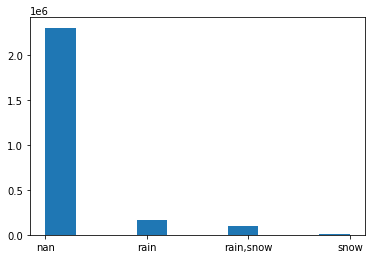

In [79]:
plt.hist(traffic_merged['preciptype'].tolist())

The below histogram shows the extremely skewed right and asymmetric distribution of precipitation amounts. Consider removing this column

(array([2.389118e+06, 3.261900e+04, 1.354800e+04, 9.838000e+03,
        5.079000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 8.420000e+02]),
 array([0.    , 0.0117, 0.0234, 0.0351, 0.0468, 0.0585, 0.0702, 0.0819,
        0.0936, 0.1053, 0.117 ]),
 <BarContainer object of 10 artists>)

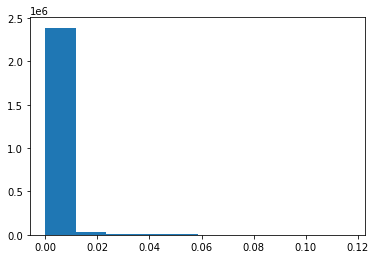

In [80]:
plt.hist(traffic_merged['precip'].tolist())

We drop the following features for the following reasons: 
 - Bus count: not related to traffic (assuming busses aren't a significant factor to flow of traffic in a segment, might be wrong, so possibly keep this) 
 - Message count: not related to traffic or weather 
 - Datetime: we already have a time column (TIME)
 - name: This is just the name of the city, which is Chicago for all columns anyway, and a proxy for location, which we already have in the segment 
 - Precipprob: Is just a prediction for precipitation, not an actual indicator of current weather
 - snow: see previous bullet 
 - winddir: angle is numeric but cyclical, so it'll take some further analysis to get useful info from this 
 - windspeed: windgust is a more accurate measure of windspeed anyway, and if it's nan, then we can coerce it to the windspeed value (I believe this does not happen for this dataset) 
 - severerisk: a generalization of weather not related to physical data 
 - icon: similar to severerisk
 - stations: not a physical observation

In [81]:
traffic_merged = traffic_merged.drop(['BUS COUNT                ', 'MESSAGE COUNT', 'datetime', 'name', 'precipprob', 
               'snow', 'windspeed', 'winddir', 'severerisk', 'icon', 'stations'], axis=1)

### Removing nan values

What we wanna do here is sort the entries by time. We do this because if the entries are sorted by time, then we can fill nan values with the nearest availible time 

If we make a column which contains datetime objects, we can compare 2 time values and thus sort all the rows that way 

In [82]:
def make_std_time(row):
    return datetime.strptime(row["TIME"], '%m/%d/%Y %I:%M:%S %p')
traffic_merged["std_datetime"] = traffic.apply(make_std_time, axis=1)
traffic_merged

,TIME,SEGMENTID,SPEED,temp,feelslike,dew,humidity,precip,preciptype,snowdepth,windgust,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,std_datetime
0,04/30/2018 11:50:28 PM,1133,27,67.2,67.2,29.4,24.24,0.0,NaN,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28
1,04/30/2018 11:50:28 PM,1133,27,67.2,67.2,29.4,24.24,0.0,NaN,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28
2,04/30/2018 11:50:28 PM,1153,23,67.2,67.2,29.4,24.24,0.0,NaN,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28
3,04/30/2018 11:50:28 PM,1153,23,67.2,67.2,29.4,24.24,0.0,NaN,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28
4,04/30/2018 11:50:28 PM,1178,16,67.2,67.2,29.4,24.24,0.0,NaN,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577596,04/01/2018 12:01:06 AM,203,18,32.9,27.8,14.3,45.72,0.0,NaN,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06
2577597,04/01/2018 12:01:06 AM,204,24,32.9,27.8,14.3,45.72,0.0,NaN,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06
2577598,04/01/2018 12:01:06 AM,205,24,32.9,27.8,14.3,45.72,0.0,NaN,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06
2577599,04/01/2018 12:01:06 AM,206,24,32.9,27.8,14.3,45.72,0.0,NaN,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06


In [83]:
traffic_merged = traffic_merged.sort_values(by=['std_datetime','SEGMENTID'])

In [84]:
traffic_merged.ffill().bfill()

,TIME,SEGMENTID,SPEED,temp,feelslike,dew,humidity,precip,preciptype,snowdepth,windgust,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,conditions,std_datetime
2577550,04/01/2018 12:01:06 AM,1,25,32.9,27.8,14.3,45.72,0.0,rain,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06
2577551,04/01/2018 12:01:06 AM,2,20,32.9,27.8,14.3,45.72,0.0,rain,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06
2577552,04/01/2018 12:01:06 AM,7,32,32.9,27.8,14.3,45.72,0.0,rain,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06
2577553,04/01/2018 12:01:06 AM,8,27,32.9,27.8,14.3,45.72,0.0,rain,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06
2577554,04/01/2018 12:01:06 AM,9,28,32.9,27.8,14.3,45.72,0.0,rain,0.0,13.2,1026.0,78.4,9.9,496.0,1.8,5.0,Partially cloudy,2018-04-01 00:01:06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,04/30/2018 11:50:28 PM,1305,20,67.2,67.2,29.4,24.24,0.0,rain,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28
80,04/30/2018 11:50:28 PM,1307,25,67.2,67.2,29.4,24.24,0.0,rain,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28
81,04/30/2018 11:50:28 PM,1307,25,67.2,67.2,29.4,24.24,0.0,rain,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28
82,04/30/2018 11:50:28 PM,1309,29,67.2,67.2,29.4,24.24,0.0,rain,0.0,27.7,1014.9,24.2,9.9,0.0,0.0,0.0,Partially cloudy,2018-04-30 23:50:28


In [85]:
for column in traffic_merged.columns:
    if traffic_merged[column].isnull().any():
        # If NaN values are found, raise an exception
        #print(column)
        raise Exception(f"NaN values found in column {column}")

Exception: NaN values found in column temp

In [86]:
for column in traffic_merged.columns:
    nan_count_before = traffic_merged[column].isnull().sum()
    if nan_count_before > 0:
        print(f"Processing column: {column}")

        traffic_merged[column] = traffic_merged[column].ffill().bfill()

        most_common_value = traffic_merged[column].mode()[0]

        nan_count_after = traffic_merged[column].isnull().sum()
        if nan_count_after > 0:
            traffic_merged[column].fillna(most_common_value, inplace=True)

        if traffic_merged[column].isnull().any():
            raise Exception(f"NaN values still present in {column} after filling!")

        unique_values = traffic_merged[column].unique()[:10]
        nan_filled = nan_count_before - nan_count_after

        print(f"Used '{most_common_value}' to fill {nan_filled} NaNs in {column}")
        print(f"First 10 unique values in {column} after filling NaNs: {unique_values}\n")

Processing column: temp
Used '34.7' to fill 126557 NaNs in temp
First 10 unique values in temp after filling NaNs: [32.9 33.6 32.4 31.3 30.1 28.2 27.3 26.2 27.6 29.3]

Processing column: feelslike
Used '31.5' to fill 126557 NaNs in feelslike
First 10 unique values in feelslike after filling NaNs: [27.8 24.8 23.2 22.8 22.  18.5 18.6 16.7 17.6 21.5]

Processing column: dew
Used '38.0' to fill 126557 NaNs in dew
First 10 unique values in dew after filling NaNs: [14.3 19.9 18.7 17.3 15.6 12.9 11.5 10.7 10.  10.4]

Processing column: humidity
Used '94.79' to fill 126557 NaNs in humidity
First 10 unique values in humidity after filling NaNs: [45.72 56.84 56.78 55.73 54.34 52.1  50.89 51.46 46.95 44.74]

Processing column: precip
Used '0.0' to fill 126557 NaNs in precip
First 10 unique values in precip after filling NaNs: [0.    0.017 0.001 0.034 0.004 0.011 0.037 0.014 0.003 0.023]

Processing column: preciptype
Used 'rain,snow' to fill 2306808 NaNs in preciptype
First 10 unique values in pr

### Adding extra columns

#### Turning time into numerical data

We make the day of week and time seperate numeric variables, and we hypothesize that the combo of those 2 will have good predictive power

Note that this might backfire a lot, as traffic speeds over the day can be (and I'm guessing probably is) multimodal, and high values of either day or time closely line up with low values of the next day/week (respectively), so this might be a bad way to do it. Despite that, without knowledge of time series data processing techniques, I have no idea what else to do

In [87]:
def add_weekday(row):
    cur_time = row["std_datetime"]
    return cur_time.weekday()
def add_time(row):
    cur_time = row["std_datetime"]
    return (cur_time.hour*3600)+(cur_time.minute*60)+(cur_time.second)

In [88]:
traffic_merged["weekday"]=traffic_merged.apply(add_weekday, axis=1)
traffic_merged["time_of_day"]=traffic_merged.apply(add_time, axis=1)

#### Replacing segment with lat/long

We replace segmens with a column for latitiude and longitude, that way we have a numeric value for which position is a meaningful metric

Like with the time data, this is likely mutlimodal and doing simple regression on it will likely yield poor results

We really should have done a different data set. But we're in too deep now and I'm really just hoping that us just using the techniques will give us a passing grade

In [89]:
segments_dict = {}
for i in segments.iterrows():
    #print(i[1]["SEGMENTID"])
    long = (i[1]["START_LONGITUDE"] + i[1]["END_LONGITUDE"])/2
    lat = (i[1][" START_LATITUDE"] + i[1][" END_LATITUDE"])/2
    segments_dict[i[1]["SEGMENTID"]] = (lat, long)

In [90]:
def add_lat(row):
    return segments_dict[row["SEGMENTID"]][0]
def add_long(row):
    return segments_dict[row["SEGMENTID"]][1]

In [91]:
traffic_merged["lat"] = traffic_merged.apply(add_lat, axis=1)
traffic_merged["long"] = traffic_merged.apply(add_long, axis=1)

#### One-hot encoding conditions (the only categorical variable)

In [92]:
def is_clear(row):
    return 1 if row["conditions"]=="Clear" else 0
def is_overcast(row):
    return 1 if row["conditions"]=="Overcast" else 0
def is_partcloud(row):
    return 1 if row["conditions"]=="Partially cloudy" else 0
def is_rainovercase(row):
    return 1 if row["conditions"]=="Rain, Overcast" else 0
def is_snowovercast(row):
    return 1 if row["conditions"]=="Snow, Overcast" else 0
def is_snowrainovercast(row):
    return 1 if row["conditions"]=="Snow, Rain, Overcast" else 0

In [93]:
traffic_merged["is_clear"] = traffic_merged.apply(is_clear, axis=1)
traffic_merged["is_overcast"] = traffic_merged.apply(is_overcast, axis=1)
traffic_merged["is_partcloud"] = traffic_merged.apply(is_partcloud, axis=1)
traffic_merged["is_rainovercase"] = traffic_merged.apply(is_rainovercase, axis=1)
traffic_merged["is_snowovercast"] = traffic_merged.apply(is_snowovercast, axis=1)
traffic_merged["is_snowrainovercast"] = traffic_merged.apply(is_snowrainovercast, axis=1)

In [94]:
traffic_merged[["conditions", "is_clear","is_overcast","is_partcloud", "is_rainovercase", "is_snowovercast", "is_snowrainovercast"]].sample(10)

,conditions,is_clear,is_overcast,is_partcloud,is_rainovercase,is_snowovercast,is_snowrainovercast
2433537,Partially cloudy,0,0,1,0,0,0
1093168,"Snow, Rain, Overcast",0,0,0,0,0,1
1850637,"Snow, Rain, Overcast",0,0,0,0,0,1
454340,Partially cloudy,0,0,1,0,0,0
801653,Partially cloudy,0,0,1,0,0,0
2166212,Partially cloudy,0,0,1,0,0,0
239798,Clear,1,0,0,0,0,0
593838,Partially cloudy,0,0,1,0,0,0
2076877,Partially cloudy,0,0,1,0,0,0
1920466,Partially cloudy,0,0,1,0,0,0


#### Test/Train split

In [97]:
traffic_merged = traffic_merged.drop(['TIME', 'SEGMENTID', 'conditions', 'std_datetime', 'preciptype'], axis=1)
traffic_merged.columns

Index(['SPEED', 'temp', 'feelslike', 'dew', 'humidity', 'precip', 'snowdepth',
       'windgust', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'weekday', 'time_of_day',
       'lat', 'long', 'is_clear', 'is_overcast', 'is_partcloud',
       'is_rainovercase', 'is_snowovercast', 'is_snowrainovercast'],
      dtype='object')

In [109]:
np.random.seed(569)

In [110]:
# Proportion of the dataset to reserve for testing. We can change this later
test_proportion = 0.2

In [111]:
#A count to make sure we don't lose any indices
len(traffic_merged)

2577601

In [112]:
# Test/train splits, with the count at the end to make sure we have the same number of indices at the end
permutation = np.random.permutation(range(len(traffic_merged)))
test_indicies = permutation[:int(test_proportion * len(traffic_merged))]
train_indicies = permutation[int(test_proportion * len(traffic_merged)):]
np.unique(len(test_indicies)+len(train_indicies))

array([2577601])

In [113]:
# Our test dataframe is test_df, and the train dataframe is train_df
test_df = traffic_merged.iloc[test_indicies]
train_df = traffic_merged.iloc[train_indicies]

## Actual Stepwise Regression

In [119]:
train_df_X = train_df.drop(["SPEED"],axis=1)
Y = train_df["SPEED"].tolist()

In [129]:
alpha_e = alpha_r = 0.05

Forward stepwise regression

In [130]:
in_model = [] #variables in our model
out_model = train_df_X.columns.tolist() #variables not in (outside) our model
#print(out_model)

#Initialization: find which value to begin with
print("Initialization phase: we first find the predictor with lowest p-value and insert into our model")
lowest_p = 1
new_param = ''
for i in out_model:
    #print(i)
    X = train_df_X[[i]]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    if(model.pvalues[i] < lowest_p):
        lowest_p = model.pvalues[i]
        new_param = i
    #print(model.pvalues[i])
  #print(new_param, lowest_p)

in_model = [new_param]
out_model.remove(new_param)

print("We now begin forward stepwise regression")
while(True):
    print("current predictors being used:", in_model)
    #print(in_model)
    #print(out_model)

    print("Forward step")
    #Forward step
    lowest_p = 1
    new_param = ''
    for i in out_model:
        #print("Considering entering variable ", i)
        X = train_df_X[in_model + [i]]
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        #print(model.summary())
        #print("p-value of variable", i, "is", model.pvalues[i])
        if(model.pvalues[i] < lowest_p):
            lowest_p = model.pvalues[i]
            new_param = i
    print("Lowest p value found is from variable", new_param, "with value", lowest_p)
    if(lowest_p < alpha_e):
        print("this is lower than alpha_e=", alpha_e, "so we add it to our model")
        in_model.append(new_param)
        out_model.remove(new_param)
    else:
        print("This is higher than alpha_e=", alpha_e, "so we terminate procedure here")
        break

print("Final set of predictors being used:", in_model)

Initialization phase: we first find the predictor with lowest p-value and insert into our model
We now begin forward stepwise regression
current predictors being used: ['temp']
Forward step
Lowest p value found is from variable feelslike with value 0.0
this is lower than alpha_e= 0.05 so we add it to our model
current predictors being used: ['temp', 'feelslike']
Forward step
Lowest p value found is from variable cloudcover with value 0.0
this is lower than alpha_e= 0.05 so we add it to our model
current predictors being used: ['temp', 'feelslike', 'cloudcover']
Forward step
Lowest p value found is from variable solarradiation with value 0.0
this is lower than alpha_e= 0.05 so we add it to our model
current predictors being used: ['temp', 'feelslike', 'cloudcover', 'solarradiation']
Forward step
Lowest p value found is from variable weekday with value 0.0
this is lower than alpha_e= 0.05 so we add it to our model
current predictors being used: ['temp', 'feelslike', 'cloudcover', 'solarr

In [137]:
out_model = [] #variables in our model
in_model = train_df_X.columns.tolist() #variables not in (outside) our model


print("We now begin stepwise regression")
while(True):
    print("current predictors being used:", in_model)
  
    print("Backward step")
    #Backward step
    remove_these = []
    X = train_df_X[in_model]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    for i in in_model:
        #print("Considering removing variable", i)
        #print("p-value of variable", i, "is", model.pvalues[i])
        if(model.pvalues[i] > alpha_r):
            print("With the new model, p-value found greater than alpha_r=", alpha_r)
            print("Remove variable", i, "with p-value", model.pvalues[i])
            remove_these.append(i)
    if(remove_these == []):
        print("No variables removed. All p-values remain statistically significant at value above alpha_r=", alpha_r)
        break
    for i in remove_these:
        out_model.append(i)
        in_model.remove(i)
print("Final set of predictors being used:", in_model)

We now begin stepwise regression
current predictors being used: ['temp', 'feelslike', 'dew', 'humidity', 'precip', 'snowdepth', 'windgust', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'weekday', 'time_of_day', 'lat', 'long', 'is_clear', 'is_overcast', 'is_partcloud', 'is_rainovercase', 'is_snowovercast', 'is_snowrainovercast']
Backward step
With the new model, p-value found greater than alpha_r= 0.05
Remove variable dew with p-value 0.9746473843975114
With the new model, p-value found greater than alpha_r= 0.05
Remove variable cloudcover with p-value 0.5209271513338615
With the new model, p-value found greater than alpha_r= 0.05
Remove variable solarenergy with p-value 0.5437612672128098
current predictors being used: ['temp', 'feelslike', 'humidity', 'precip', 'snowdepth', 'windgust', 'sealevelpressure', 'visibility', 'solarradiation', 'uvindex', 'weekday', 'time_of_day', 'lat', 'long', 'is_clear', 'is_overcast', 'is_partcloud', 'is_rain

In [140]:
X = train_df_X[in_model]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3230.
Date:                Wed, 10 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:44:54   Log-Likelihood:            -7.1181e+06
No. Observations:             2062081   AIC:                         1.424e+07
Df Residuals:                 2062061   BIC:                         1.424e+07
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 636.5215      7.290     87.320      0.000     622.234     650.809
temp                   -0.0241      0.004     -6.112      0.000      -0.032      -0.016
feelslike               0.0169      0.003      5.438      0.000       0.011       0.023
humidity                0.0030      0.000      6.138      0.000       0.002       0.004
precip                  8.6972      1.371      6.343      0.000       6.010      11.384
snowdepth              -0.2898      0.029     -9.867      0.000      -0.347      -0.232
windgust               -0.0079      0.001     -6.269      0.000      -0.010      -0.005
sealevelpressure        0.0099      0.001      9.798      0.000       0.008       0.012
visibility              0.0613      0.004     15.546      0.000       0.054       0.069
solarradiation         -0.0021      0.000     -9.293      0.000      -0.002      -0.002
uvindex                 0.0563      0.022      2.574      0.010       0.013       0.099
weekday                 0.1145      0.003     38.255      0.000       0.109       0.120
time_of_day         -1.682e-05   2.72e-07    -61.759      0.000   -1.74e-05   -1.63e-05
lat                   -12.8775      0.070   -182.984      0.000     -13.015     -12.740
long                    2.1579      0.103     20.876      0.000       1.955       2.360
is_clear              106.4027      1.215     87.555      0.000     104.021     108.785
is_overcast           105.7093      1.215     87.001      0.000     103.328     108.091
is_partcloud          106.0276      1.215     87.263      0.000     103.646     108.409
is_rainovercase       105.1850      1.215     86.548      0.000     102.803     107.567
is_snowovercast       107.3632      1.226     87.574      0.000     104.960     109.766
is_snowrainovercast   105.8337      1.216     87.043      0.000     103.451     108.217
==============================================================================
Omnibus:                   520682.906   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1570231.022
Skew:                           1.309   Prob(JB):                         0.00
Kurtosis:                       6.379   Cond. No.                     3.53e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.54e-18. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [136]:
in_model = [] #variables in our model
out_model = train_df_X.columns.tolist() #variables not in (outside) our model

#Initialization: find which value to begin with
print("Initialization phase: we first find the predictor with lowest p-value and insert into our model")
lowest_p = 1
new_param = ''
for i in out_model:
    X = train_df_X[[i]]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    if(model.pvalues[i] < lowest_p):
        lowest_p = model.pvalues[i]
        new_param = i
    #print(model.pvalues[i])
  #print(new_param, lowest_p)

in_model = [new_param]
out_model.remove(new_param)

print("We now begin stepwise regression")
while(True):
    print("current predictors being used:", in_model)
    #print(in_model)
    #print(out_model)

    print("Forward step")
    #Forward step
    lowest_p = 1
    new_param = ''
    for i in out_model:
        #print("Considering entering variable ", i)
        X = train_df_X[in_model + [i]]
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        #print(model.summary())
        #print("p-value of variable", i, "is", model.pvalues[i])
        if(model.pvalues[i] < lowest_p):
            lowest_p = model.pvalues[i]
            new_param = i
    print("Lowest p value found is from variable", new_param, "with value", lowest_p)
    if(lowest_p < alpha_e):
        print("this is lower than alpha_e=", alpha_e, "so we add it to our model")
        in_model.append(new_param)
        out_model.remove(new_param)
    else:
        print("This is higher than alpha_e=", alpha_e, "so we terminate procedure here")
        break


    print("Backward step")
    #Backward step
    remove_these = []
    X = train_df_X[in_model]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit()
    for i in in_model:
        #print("Considering removing variable", i)
        #print("p-value of variable", i, "is", model.pvalues[i])
        if(model.pvalues[i] > alpha_r):
            print("With the new model, p-value found greater than alpha_r=", alpha_r)
            print("Remove variable", i, "with p-value", model.pvalues[i])
            remove_these.append(i)
    if(remove_these == []):
        print("No variables removed. All p-values remain statistically significant at value above alpha_r=", alpha_r)
    for i in remove_these:
        print(out_model)
        in_model.append(i)
        out_model.remove(i)

print("Final set of predictors being used:", in_model)

Initialization phase: we first find the predictor with lowest p-value and insert into our model
We now begin stepwise regression
current predictors being used: ['temp']
Forward step
Lowest p value found is from variable feelslike with value 0.0
this is lower than alpha_e= 0.05 so we add it to our model
Backward step
No variables removed. All p-values remain statistically significant at value above alpha_r= 0.05
current predictors being used: ['temp', 'feelslike']
Forward step
Lowest p value found is from variable cloudcover with value 0.0
this is lower than alpha_e= 0.05 so we add it to our model
Backward step
No variables removed. All p-values remain statistically significant at value above alpha_r= 0.05
current predictors being used: ['temp', 'feelslike', 'cloudcover']
Forward step
Lowest p value found is from variable solarradiation with value 0.0
this is lower than alpha_e= 0.05 so we add it to our model
Backward step
No variables removed. All p-values remain statistically signific

ValueError: list.remove(x): x not in list